# Data Handling 

In [133]:
!pip install albumentations

In [134]:
import zipfile
import os
import cv2
import yaml
import json
import shutil
import numpy as np
from glob import glob
from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split

## Path to your zip file (replace 'data.zip' with your file's name)

In [135]:
zip_file_path = '/teamspace/studios/this_studio/data/yolo-new-dataset.zip'

## Create a safe extraction path (using home directory)

In [136]:
# extract_base = os.path.expanduser('~')  # Gets your home directory
# extract_directory = os.path.join(extract_base, 'yolo-extracted')
extract_directory = os.path.join('data', 'yolo-extracted')

## Create directory if it doesn't exist (with safety checks)

In [137]:
try:
    os.makedirs(extract_directory, exist_ok=True)
    print(f"Created extraction directory: {extract_directory}")
except PermissionError:
    print(f"ERROR: Cannot create directory at {extract_directory}")
    print("Trying temporary directory instead...")
    import tempfile
    extract_directory = tempfile.mkdtemp()

Created extraction directory: data/yolo-extracted


## Attempt extraction with error handling

In [138]:
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_directory)
    print("\nExtraction successful!")
    print(f"Zip file location: {zip_file_path}")
    print(f"Extracted to: {extract_directory}")
    
except FileNotFoundError:
    print(f"\nERROR: Zip file not found at {zip_file_path}")
    print("Check the file path and permissions")
except zipfile.BadZipFile:
    print("\nERROR: File is not a valid ZIP archive")
except PermissionError as e:
    print(f"\nPERMISSION ERROR: {e}")
    print("Try one of these solutions:")
    print("1. Run the script with elevated permissions (sudo)")
    print("2. Choose a different extraction location")
except Exception as e:
    print(f"\nUNEXPECTED ERROR: {e}")


Extraction successful!
Zip file location: /teamspace/studios/this_studio/data/yolo-new-dataset.zip
Extracted to: data/yolo-extracted


## Optional: List extracted files

In [139]:
if os.path.exists(extract_directory):
    print("\nExtracted files:")
    for root, dirs, files in os.walk(extract_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f" - {file}")


Extracted files:
Directory: data/yolo-extracted
 - classes.txt
 - data.yaml
 - notes.json
Directory: data/yolo-extracted/labels
 - 84877eb2-image_2025-03-12_13-23-47.txt
 - bee01a87-image_2025-03-12_12-45-21.txt
 - a95a6529-image_2025-03-12_13-10-57.txt
 - d68ae795-image_2025-03-10_16-38-00.txt
 - 27613c2f-image_2025-03-10_15-53-04.txt
 - ca1a03b7-WIN_20241214_19_07_12_Pro.txt
 - e625e38b-WIN_20241214_16_31_51_Pro.txt
 - 8b327ca5-image_2025-03-16_12-26-13.txt
 - 8f699f26-image_2025-03-12_13-35-40.txt
 - 19c4ddbc-WIN_20241214_17_02_09_Pro.txt
 - 260f50e6-image_2025-03-10_16-30-11.txt
 - 3bba2312-WIN_20241214_19_41_40_Pro.txt
 - 77450625-image_2025-03-15_16-47-15.txt
 - 50080253-image_2025-03-16_12-39-40.txt
 - 87efa7f6-WIN_20241214_18_53_53_Pro.txt
 - bf6baa3e-WIN_20241214_17_15_04_Pro.txt
 - ae94c376-image_2025-03-10_16-37-52.txt
 - 7fa747d0-WIN_20241214_19_13_25_Pro.txt
 - 60de12d0-WIN_20241214_19_16_47_Pro.txt
 - 9ed35e0e-image_2025-03-12_13-07-37.txt
 - 7d806ad6-image_2025-03-16_12

## Configuration

In [140]:
extract_directory = 'data/yolo-extracted'  # Update this path
notes_path = os.path.join(os.path.expanduser(extract_directory), 'notes.json')
test_size = 0.15  # 15% for test
val_size = 0.15   # 15% of remaining data for validation (≈13% of total)

## Expand user directory if needed

In [141]:
extract_directory = os.path.expanduser(extract_directory)

## Create directory structure

In [142]:
dir_structure  = {
    'images': ['train', 'val', 'test'],
    'labels': ['train', 'val', 'test']
}

In [143]:
for main_dir, sub_dirs in dir_structure.items():
    for sub_dir in sub_dirs:
        dir_path = os.path.join(extract_directory, main_dir, sub_dir)
        os.makedirs(dir_path, exist_ok=True)

## Load class information from notes.json

In [144]:
with open(notes_path, 'r') as f:
    notes = json.load(f)
classes = sorted([c['name'] for c in notes['categories']], 
                key=lambda x: next(c['id'] for c in notes['categories'] if c['name'] == x))

## Define critical paths

In [145]:
image_dir = os.path.join(extract_directory, 'images')  # Fixed here
label_dir = os.path.join(extract_directory, 'labels')

## Get image files

In [146]:
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
image_files = [f for f in os.listdir(image_dir) 
              if os.path.splitext(f)[1].lower() in image_extensions]

## Split files

In [147]:
train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=val_size, random_state=42)

## Modified function with explicit paths


In [148]:
def move_files(files, split_type, src_image_dir, src_label_dir):
    for f in files:
        # Image paths
        src_img = os.path.join(src_image_dir, f)
        dst_img = os.path.join(src_image_dir, split_type, f)
        
        # Label paths
        label_file = os.path.splitext(f)[0] + '.txt'
        src_lbl = os.path.join(src_label_dir, label_file)
        dst_lbl = os.path.join(src_label_dir, split_type, label_file)
        
        # Move files with existence checks
        if os.path.exists(src_img):
            shutil.move(src_img, dst_img)
        if os.path.exists(src_lbl):
            shutil.move(src_lbl, dst_lbl)

In [149]:
print("\nStarting file organization...")
move_files(train_files, 'train', image_dir, label_dir)
move_files(val_files, 'val', image_dir, label_dir)
move_files(test_files, 'test', image_dir, label_dir)


Starting file organization...


### Function to count images and labels

In [150]:
def report_data_stats(image_dir, label_dir, phase):
    image_files = glob(os.path.join(image_dir, phase, '*.jpg'))
    label_files = glob(os.path.join(label_dir, phase, '*.txt'))
    if not image_files:
        print(f"{phase.upper()} - No images found.")
        return
    img_shape = cv2.imread(image_files[0]).shape if image_files else None
    print(f"{phase.upper()} - Images: {len(image_files)}, Labels: {len(label_files)}, Sample shape: {img_shape}")

### Function to perform data augmentation

In [151]:
def augment_yolo_data(image_dir, label_dir, phase, augmentations, num_aug=2):
    img_folder = os.path.join(image_dir, phase)
    lbl_folder = os.path.join(label_dir, phase)
    
    image_files = glob(os.path.join(img_folder, '*.jpg'))

    for img_path in tqdm(image_files, desc=f"Augmenting {phase}"):
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(lbl_folder, base_name + '.txt')

        if not os.path.exists(label_path):
            continue

        # Load image and labels
        image = cv2.imread(img_path)
        h, w = image.shape[:2]

        with open(label_path, 'r') as f:
            yolo_labels = f.readlines()

        bboxes = []
        class_ids = []
        for line in yolo_labels:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x_min = (x - bw / 2) * w
            y_min = (y - bh / 2) * h
            x_max = (x + bw / 2) * w
            y_max = (y + bh / 2) * h
            bboxes.append([x_min, y_min, x_max, y_max])
            class_ids.append(int(cls))

        for i in range(num_aug):
            aug = augmentations(image=image, bboxes=bboxes, class_labels=class_ids)
            aug_img = aug['image']
            aug_boxes = aug['bboxes']
            aug_labels = aug['class_labels']

            # Save augmented image
            aug_img_name = f"{base_name}_aug{i}.jpg"
            aug_lbl_name = f"{base_name}_aug{i}.txt"
            aug_img_path = os.path.join(img_folder, aug_img_name)
            aug_lbl_path = os.path.join(lbl_folder, aug_lbl_name)

            cv2.imwrite(aug_img_path, aug_img)

            # Convert boxes back to YOLO
            with open(aug_lbl_path, 'w') as f:
                for box, cls in zip(aug_boxes, aug_labels):
                    x_min, y_min, x_max, y_max = box
                    x = ((x_min + x_max) / 2) / w
                    y = ((y_min + y_max) / 2) / h
                    bw = (x_max - x_min) / w
                    bh = (y_max - y_min) / h
                    f.write(f"{cls} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

### Define the augmentation pipeline

In [152]:
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

### Directories

In [153]:
phases = ['train', 'val', 'test']

print("\n📊 Data before augmentation:")
for phase in phases:
    report_data_stats(image_dir, label_dir, phase)

print("\n🚀 Performing augmentation...")
for phase in phases:
    augment_yolo_data(image_dir, label_dir, phase, augmentation_pipeline)

print("\n📊 Data after augmentation:")
for phase in phases:
    report_data_stats(image_dir, label_dir, phase)


📊 Data before augmentation:
TRAIN - Images: 1977, Labels: 1977, Sample shape: (480, 640, 3)
VAL - Images: 350, Labels: 350, Sample shape: (480, 640, 3)
TEST - Images: 411, Labels: 411, Sample shape: (1080, 1920, 3)

🚀 Performing augmentation...


Augmenting train:   2%|▏         | 32/1977 [00:01<01:22, 23.67it/s]

Augmenting test: 100%|██████████| 411/411 [00:12<00:00, 33.99it/s]


📊 Data after augmentation:
TRAIN - Images: 5931, Labels: 5931, Sample shape: (480, 640, 3)
VAL - Images: 1050, Labels: 1050, Sample shape: (480, 640, 3)
TEST - Images: 1233, Labels: 1233, Sample shape: (480, 640, 3)


### Count and Plot Class Distribution (Before Balancing)

In [168]:
import os
import shutil
import matplotlib.pyplot as plt
from collections import defaultdict
from glob import glob
import random

In [169]:
def count_class_distribution(label_dir, phases):
    class_counts = defaultdict(int)
    for phase in phases:
        phase_dir = os.path.join(label_dir, phase)
        for label_file in os.listdir(phase_dir):
            if label_file.endswith(".txt"):
                with open(os.path.join(phase_dir, label_file)) as f:
                    for line in f:
                        try:
                            cls = int(float(line.strip().split()[0]))
                            class_counts[cls] += 1
                        except:
                            continue
    return class_counts

In [170]:
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = [class_counts[c] for c in classes]

    plt.figure(figsize=(8, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(classes)
    plt.grid(axis='y')
    plt.show()

🔢 Class distribution before balancing:
defaultdict(<class 'int'>, {4: 1185, 1: 1899, 5: 1851, 3: 435, 2: 198, 0: 744})


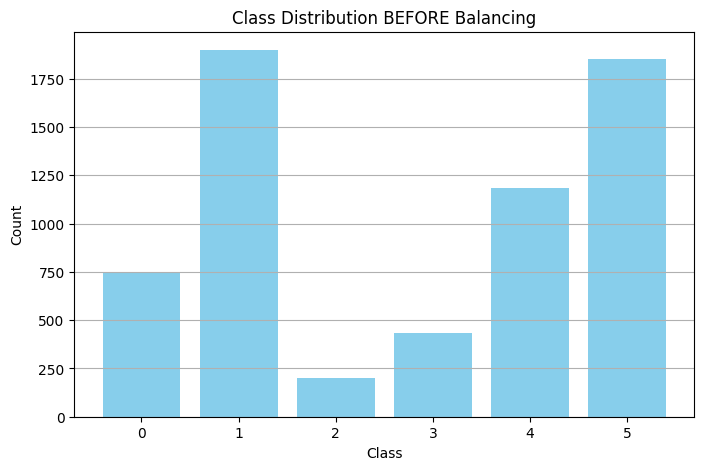

In [171]:
class_counts_before = count_class_distribution(label_dir, phases=['train'])
print("🔢 Class distribution before balancing:")
print(class_counts_before)
plot_class_distribution(class_counts_before, "Class Distribution BEFORE Balancing")

### Balancing Logic + Save to yolo-extracted-balanced

In [172]:
def balance_classes(image_dir, label_dir, output_dir, target_class_count):
    os.makedirs(output_dir, exist_ok=True)
    phases = ['train']  # Only balance training data

    for phase in phases:
        img_src = os.path.join(image_dir, phase)
        lbl_src = os.path.join(label_dir, phase)
        img_dst = os.path.join(output_dir, phase)
        lbl_dst = os.path.join(output_dir.replace("image", "label"), phase)

        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(lbl_dst, exist_ok=True)

        class_map = defaultdict(list)

        # Group image/label files by class
        for lbl_file in os.listdir(lbl_src):
            if not lbl_file.endswith(".txt"): continue
            with open(os.path.join(lbl_src, lbl_file)) as f:
                lines = f.readlines()

            classes_in_file = set(int(float(line.split()[0])) for line in lines)
            for cls in classes_in_file:
                class_map[cls].append(lbl_file)

        # Duplicate minority class samples to balance
        for cls, files in class_map.items():
            files_needed = target_class_count - len(files)
            all_files = files.copy()

            # Save original first
            for file in all_files:
                shutil.copy(os.path.join(lbl_src, file), os.path.join(lbl_dst, file))
                img_file = file.replace(".txt", ".jpg")
                shutil.copy(os.path.join(img_src, img_file), os.path.join(img_dst, img_file))

            # Duplicate if needed
            if files_needed > 0:
                for i in range(files_needed):
                    src_file = random.choice(all_files)
                    new_lbl_name = src_file.replace(".txt", f"_dup{i}.txt")
                    new_img_name = src_file.replace(".txt", f"_dup{i}.jpg")

                    shutil.copy(os.path.join(lbl_src, src_file), os.path.join(lbl_dst, new_lbl_name))
                    shutil.copy(os.path.join(img_src, src_file.replace(".txt", ".jpg")), os.path.join(img_dst, new_img_name))

### Run the Balancer

In [173]:
output_balanced_dir = image_dir.replace("yolo-extracted", "yolo-extracted-balanced")

max_class = max(class_counts_before.values())
balance_classes(image_dir, label_dir, output_balanced_dir, max_class)

### Count and Plot After Balancing

🔁 Class distribution AFTER balancing:
defaultdict(<class 'int'>, {4: 2389, 1: 2141, 3: 2055, 5: 2310, 0: 2029, 2: 1899})


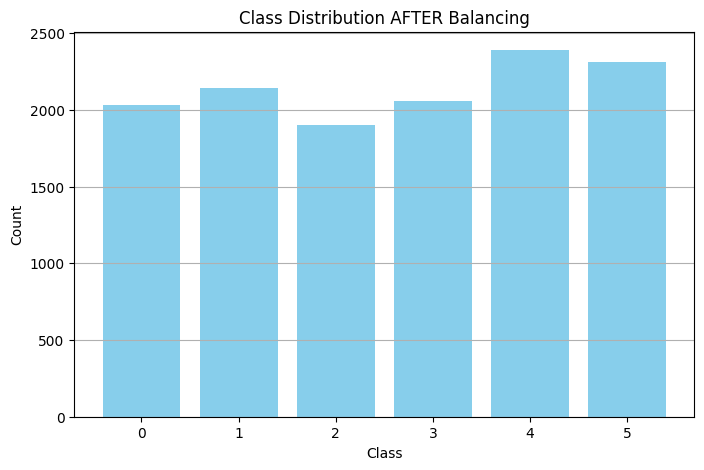

In [174]:
label_dir_balanced = label_dir.replace("yolo-extracted", "yolo-extracted-balanced")
class_counts_after = count_class_distribution(label_dir_balanced, phases=['train'])

print("🔁 Class distribution AFTER balancing:")
print(class_counts_after)
plot_class_distribution(class_counts_after, "Class Distribution AFTER Balancing")

## Create YAML

In [ ]:
yaml_content = {
    'train': os.path.join('images', 'train'),
    'val': os.path.join('images', 'val'),
    'test': os.path.join('images', 'test'),
    'nc': len(classes),
    'names': classes,
    'info': notes.get('info', {})
}

In [ ]:
yaml_path = os.path.join(extract_directory, 'data.yaml')

In [ ]:
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, sort_keys=False)

print(f"\nDataset prepared successfully at: {extract_directory}")


Dataset prepared successfully at: data/yolo-extracted
